### Integrantes
Christian Gómez 2021114018
Miguel Amézquita 2021114026
Maria Margarita Matos Varela 2019119017

# Descripción del Problema

Este Notebook aborda un problema de *clasificación supervisada*, donde el objetivo es categorizar imágenes de mangos en clases definidas 
("maduros" o "dañados"). Para ello, se emplea un conjunto de datos con imágenes previamente etiquetadas, 
dividido en dos subconjuntos: *entrenamiento* y *validación*.

El modelo está basado en redes neuronales convolucionales, implementadas mediante la biblioteca tensorflow.keras.
Cada imagen en el conjunto de datos representa una observación, y las etiquetas indican la clase correspondiente.

## Variables del Conjunto de Datos
1. *Imágenes*: Imágenes de tamaño 224x224 en escala de grises
2. *Clases*: Categorías asignadas a cada imagen.

## Instalación de librerías
Se intala numpy con la version 1.26.4 debido a errores con versiones mas recientes en la libreria pandas integrada en tensorflow
fuentes: https://techoverflow.net/2024/07/23/how-to-fix-numpy-dtype-size-changed-may-indicate-binary-incompatibility-expected-96-from-c-header-got-88-from-pyobject/

In [ ]:
pip install numpy==1.26.4

In [ ]:
pip install tensorflow

In [ ]:
pip install keras

In [ ]:
pip install pandas

In [ ]:
pip install seaborn

In [ ]:
pip install opencv-python

In [ ]:
pip install scikit-learn


train:

validation:


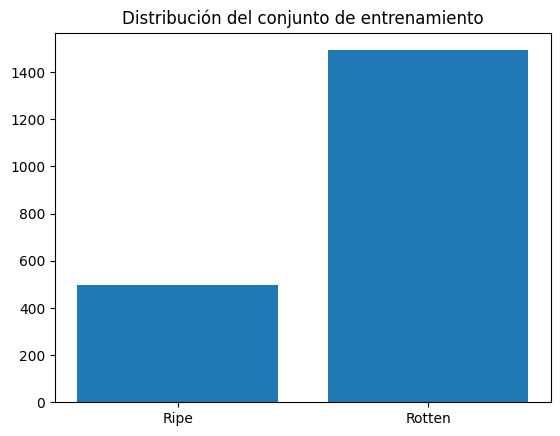

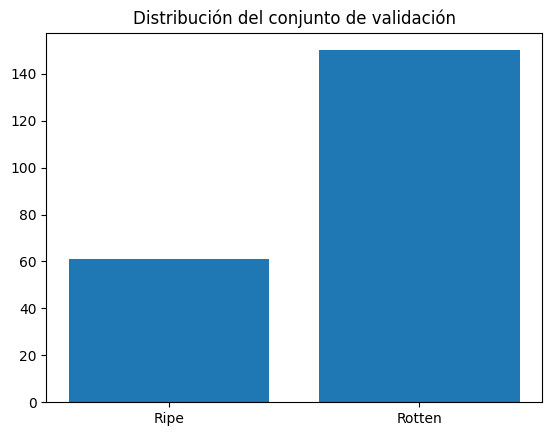

In [8]:
import os
import matplotlib.pyplot as pyplot

train_dir = 'dataset/train'
val_dir = 'dataset/validation'

image_count = {}

for directory in [train_dir, val_dir]:
    conjunto = directory.split('/')[-1]
    print(f"\n{conjunto}:")
    for category in os.listdir(directory):
        image_count.setdefault(conjunto, {})
        count = len(os.listdir(os.path.join(directory, category)))
        image_count[conjunto][category] = count

pyplot.title('Distribución del conjunto de entrenamiento')
pyplot.bar(image_count['train'].keys(), image_count['train'].values())
pyplot.show()

pyplot.title('Distribución del conjunto de validación')
pyplot.bar(image_count['validation'].keys(), image_count['validation'].values())
pyplot.show()

# Preparacion del modelo

Se utilizó un modelo de redes neuronales convolucionales para la extracción de las características de las imágenes,
inicialmente se configuró una primera capa de entrada con 32 filtros con núcleos de tamaño 3x3 con su respectiva capa de pooling tamaño 2x2, reduce la dimensión de la entrada a la mitad, tomando los valores máximos.
Posteriormente se añadieron cuatro capas más, duplicando la cantidad de filtros con respecto al anterior.
Todas estas capas fueron configuradas con *padding* en *same*, lo que significa que no perderan dimensión al aplicar la convolución, además de que todas usan la función de activación relu vista en clase.
Continuando, se  agregó una capa para aplanar las salidas de la ultima capa, generando una salida lineal.

Se importan las librerias requeridas para crear el modelo como tensorflow y keras y se hace un ajuste en la clase tensorflow debido a errores en la funcion model.fit al usar funcion con decorador en TF 2.0 que provocaba eagerly
fuentes: https://stackoverflow.com/questions/58352326/running-the-tensorflow-2-0-code-gives-valueerror-tf-function-decorated-functio

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models
tf.config.run_functions_eagerly(True)

Primero se hizo una prueba utilizando la configuración que se muestra a continuación.
Se obtuvo un buen rendimiento, un accuracy de 96% con los datos de entrenamiento, y 95% con los de validación.
Sin embargo, el tamaño del modelo era excesivo, ocupaba alrededor de 100MB

In [ ]:
def crear_clasificador_mango(forma_entrada=(224, 224, 1), num_clases=2):
    modelo = models.Sequential()
    
    # Primera configuracion
    
    # Primera capa convolucional
    modelo.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=forma_entrada))
    modelo.add(layers.MaxPooling2D((2, 2)))

    # Segunda capa convolucional
    modelo.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    modelo.add(layers.MaxPooling2D((2, 2)))

    # Tercera capa convolucional
    modelo.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    modelo.add(layers.MaxPooling2D((2, 2)))

    # Cuarta capa convolucional
    modelo.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    modelo.add(layers.MaxPooling2D((2, 2)))

    # Quinta capa convolucional
    modelo.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    modelo.add(layers.MaxPooling2D((2, 2)))

    # Capas completamente conectadas
    modelo.add(layers.Flatten())
    modelo.add(layers.Dense(1024, activation='relu'))
    
    # Funcion dropout
    modelo.add(layers.Dropout(0.5))

    # Capa de salida
    modelo.add(layers.Dense(num_clases, activation='softmax'))

    # Compilación del modelo
    modelo.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return modelo

Dado que la configuración anterior utilizaba mucha memoria, decidimos reducir la cantidad de filtros en las capas convolucionales, ahora iniciando en 24, y duplicando la cantidad conforme se avanza. Además se cambió a un drop out más pequeño para evitar un subajuste del modelo. 

In [10]:
def crear_clasificador_mango(forma_entrada=(224, 224, 1), num_clases=2):
    modelo = models.Sequential()

    # Segunda configuracion Mejor Desempeño
    
    # Primera capa convolucional
    modelo.add(layers.Conv2D(24, (3, 3), activation='relu', padding='same', input_shape=forma_entrada))
    modelo.add(layers.MaxPooling2D((2, 2)))

    # Segunda capa convolucional
    modelo.add(layers.Conv2D(48, (3, 3), activation='relu', padding='same'))
    modelo.add(layers.MaxPooling2D((2, 2)))

    # Tercera capa convolucional
    modelo.add(layers.Conv2D(96, (3, 3), activation='relu', padding='same'))
    modelo.add(layers.MaxPooling2D((2, 2)))

    # Cuarta capa convolucional
    modelo.add(layers.Conv2D(192, (3, 3), activation='relu', padding='same'))
    modelo.add(layers.MaxPooling2D((2, 2)))

    # Quinta capa convolucional
    modelo.add(layers.Conv2D(384, (3, 3), activation='relu', padding='same'))
    modelo.add(layers.MaxPooling2D((2, 2)))

    # Capas completamente conectadas
    modelo.add(layers.Flatten())
    modelo.add(layers.Dense(768, activation='relu'))

    # Funcion dropout
    modelo.add(layers.Dropout(0.3))
     
    # Capa de salida
    modelo.add(layers.Dense(num_clases, activation='softmax'))

    # Compilación del modelo
    modelo.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return modelo

En esta configuración, se aumentó el drop out para corroborar que no se hizo un sobre ajuste del modelo con la configuración anterior, y se utilizó una función de activación sigmoid en la capa de salida, esta cambia el comportamiento de las probabilidades de salida, dejando de estar interrelacionadas.

In [ ]:
def crear_clasificador_mango(forma_entrada=(224, 224, 1), num_clases=2):
    modelo = models.Sequential()

    # Tercera configuracion
    
    # Primera capa convolucional
    modelo.add(layers.Conv2D(24, (3, 3), activation='relu', padding='same', input_shape=forma_entrada))
    modelo.add(layers.MaxPooling2D((2, 2)))

    # Segunda capa convolucional
    modelo.add(layers.Conv2D(48, (3, 3), activation='relu', padding='same'))
    modelo.add(layers.MaxPooling2D((2, 2)))

    # Tercera capa convolucional
    modelo.add(layers.Conv2D(96, (3, 3), activation='relu', padding='same'))
    modelo.add(layers.MaxPooling2D((2, 2)))

    # Cuarta capa convolucional
    modelo.add(layers.Conv2D(192, (3, 3), activation='relu', padding='same'))
    modelo.add(layers.MaxPooling2D((2, 2)))

    # Quinta capa convolucional
    modelo.add(layers.Conv2D(384, (3, 3), activation='relu', padding='same'))
    modelo.add(layers.MaxPooling2D((2, 2)))

    # Sexta capa convolucional
    modelo.add(layers.Conv2D(768, (3, 3), activation='relu', padding='same'))
    modelo.add(layers.MaxPooling2D((2, 2)))

    # Capas completamente conectadas
    modelo.add(layers.Flatten())
    modelo.add(layers.Dense(1536, activation='relu'))
    
    # Funcion dropout
    modelo.add(layers.Dropout(0.8))

    # Capa de salida
    modelo.add(layers.Dense(num_clases, activation='sigmoid'))

    # Compilación del modelo
    modelo.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return modelo

In [11]:
modelo = crear_clasificador_mango() #modelo
modelo.summary()

C:\Users\Christian\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 24)        │             240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 24)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 48)        │          10,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 48)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 96)          │          41,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 192)         │         166,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 192)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 14, 14, 384)         │         663,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 7, 7, 384)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18816)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 768)                 │      14,451,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │           1,538 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,335,234 (58.50 MB)

 Trainable params: 15,335,234 (58.50 MB)

 Non-trainable params: 0 (0.00 B)

Aquí aplicamos una técnica de aumentación de datos y preprocesamiento para enriquecer las entradas de entrenamiento del modelo

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 24
image_size = (224, 224)

# Preprocesamiento y data augmentation
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=image_size, batch_size=batch_size, class_mode='categorical', color_mode = 'grayscale')
val_generator = val_datagen.flow_from_directory(val_dir, target_size=image_size, batch_size=batch_size, class_mode='categorical', color_mode = 'grayscale')


Found 1989 images belonging to 2 classes.
Found 211 images belonging to 2 classes.


## Entrenamiento

In [13]:
# Entrenar el modelo
epochs = 20
history = modelo.fit(train_generator, epochs=epochs, validation_data=val_generator)

modelo.save('modelo_clasificador_mangos.h5') #modelo entrenado

C:\Users\Christian\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


C:\Users\Christian\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 932ms/step - accuracy: 0.7135 - loss: 0.6335

C:\Users\Christian\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


83/83 ━━━━━━━━━━━━━━━━━━━━ 80s 960ms/step - accuracy: 0.7139 - loss: 0.6328 - val_accuracy: 0.7109 - val_loss: 0.5665
Epoch 2/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 81s 971ms/step - accuracy: 0.7501 - loss: 0.4898 - val_accuracy: 0.7156 - val_loss: 0.4990
Epoch 3/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 80s 964ms/step - accuracy: 0.7397 - loss: 0.4610 - val_accuracy: 0.7109 - val_loss: 0.4530
Epoch 4/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 80s 964ms/step - accuracy: 0.8021 - loss: 0.4228 - val_accuracy: 0.7251 - val_loss: 0.4590
Epoch 5/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 79s 955ms/step - accuracy: 0.8761 - loss: 0.3014 - val_accuracy: 0.8815 - val_loss: 0.2441
Epoch 6/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 80s 957ms/step - accuracy: 0.8861 - loss: 0.2695 - val_accuracy: 0.9384 - val_loss: 0.1355
Epoch 7/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 80s 962ms/step - accuracy: 0.9410 - loss: 0.1824 - val_accuracy: 0.9336 - val_loss: 0.1637
Epoch 8/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 79s 956ms/step - accuracy: 0.9467 - loss: 0.1579 - val_accuracy: 0.947

Después de probar todas las configuraciones, se llegó a la conclusión de que la segunda configuración ofrece el mejor desempeño frente al tamaño.

## Validación
Primeramente se carga el modelo entrenado, y se define una función para cargar y ajustar las imágenes del conjunto de validación con el fin de poder aplicarlas sobre el modelo predictivo. 

In [ ]:
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

modelo = tf.keras.models.load_model('modelo_clasificador_mangos.h5')

def preprocesado_imagen(img_path):
    img = image.load_img(img_path, target_size=(224, 224), color_mode = 'grayscale')
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array

Se extrayeron las imágenes de las distintas categorías del conjunto de validación, se aplicó el preprocesamiento y se ejecutó el predictor.

Con base en los resultados, se creó la matriz de confusión y se calculó el accuracy o precisión del modelo.

In [29]:
etiquetas_verdaderas = []
predicciones = []
carpeta = "dataset/validation"
categorias = ['Ripe', 'Rotten']
#Matriz Confusion
for etiqueta, categoria in enumerate(categorias):
    categoria_path = os.path.join(carpeta, categoria)
    for imagen in os.listdir(categoria_path):
        imagen_preprocesada = preprocesado_imagen(os.path.join(categoria_path, imagen))
        prediccion = modelo.predict(imagen_preprocesada, verbose = 0)
        clase_predecida = np.argmax(prediccion)
        etiquetas_verdaderas.append(etiqueta)
        predicciones.append(clase_predecida)
            
etiquetas_verdaderas = np.array(etiquetas_verdaderas)
predicciones = np.array(predicciones)

# Crear la matriz de confusión
cm = confusion_matrix(etiquetas_verdaderas, predicciones)

print("Matriz de Confusión:")
print(cm)

accuracy = np.sum(etiquetas_verdaderas == predicciones) / len(etiquetas_verdaderas)
print("Accuracy: " + str(round(accuracy*100,2)) + "%")

C:\Users\Christian\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Matriz de Confusión:
[[ 58   3]
 [  0 150]]
Accuracy: 98.58%


En esta prueba se utilizó el clasificador con una imagen individual, para poder validarla visualmente y obtener su nivel de confianza.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
[[0.9950113  0.00498866]]
La imagen pertenece a la clase: Ripe


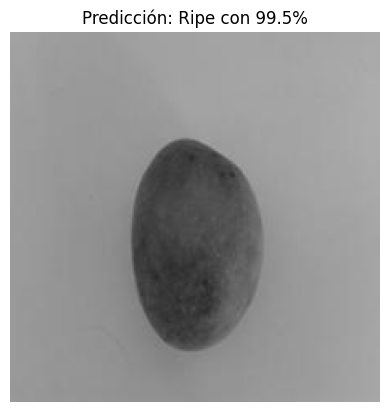

In [25]:
# Predecir la clase de una imagen
test_image_path = 'dataset/validation/Ripe/444.jpg'

test_imagen = preprocesado_imagen(test_image_path)
prediccion = modelo.predict(test_imagen)
clase_predecida = np.argmax(prediccion)
print(prediccion)
print(f"La imagen pertenece a la clase: {categorias[clase_predecida]}")

img = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(f'Predicción: {categorias[clase_predecida]} con {round(prediccion[0][clase_predecida]*100,2)}%')
plt.axis('off')
plt.show()

### Análisis de Resultados

#### Accuracy:
- El accuracy obtenido es del *98.9%*, lo que refleja un excelente desempeño general del modelo.

#### Interpretación de la matriz de Confusión:
*Datos generales:*
   - *58*: Verdaderos positivos (clase correctamente clasificada como "Maduro").
   - *150*: Verdaderos negativos (clase correctamente clasificada como "Podrido").
   - *0*: Falsos positivos (clasificados erróneamente como "Ripe" pero eran "Podrido").
   - *3*: Falsos negativos (clasificados erróneamente como "Rotten" pero eran "Maduro").
*Conclusiones clave:*
   - El modelo clasifica correctamente la mayoría de los datos, con solo *3 errores en total* sobre *211 muestras*.
   - La matriz de confusión indica que el modelo tiene un ligero desbalance  entre las clases, ya que los valores de la diagonal principal (58 y 150) son significativamente mayores que los errores.

*Análisis de errores:*
   - Los falsos negativos (3 casos) son ligeramente más comunes que los falsos positivos (0 caso). Esto indica que el modelo tiene una ligera tendencia a clasificar como "Rotten" imágenes que en realidad son "Ripe".
   - Dado que los errores son mínimos, no parece ser necesario un ajuste significativo en el modelo.

*Conclusión global:*
   - El clasificador de mango tiene un desempeño excelente, siendo capaz de identificar correctamente las clases "Maduro" y "Podrido"       con una precisión casi perfecta, por lo que si resuelve el planteamiento del problema.
   - Los pocos errores podrían ser tolerables, pero si es crítico reducirlos aún más, se podría considerar:
     - Ampliar el conjunto de datos de entrenamiento.
     - Realizar un análisis de las imágenes mal clasificadas para identificar posibles patrones en los errores (como imágenes                 difíciles o con ruido).